In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import *
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
IBMQ.load_account()
provider = IBMQ.get_provider(hub = 'ibm-q')

/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.providers.aer.noise import NoiseModel
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)
#from qiskit.circuit.library.standard_gates import U2Gate
#from qiskit.aqua.operators import WeightedPauliOperator
#from qiskit.aqua.algorithms import NumPyEigensolver

I begin with taking into account the hints given for task 4. So I first write the code assuming that the possible coefficients for Pauli terms are only [-1, -0.5, 0, 0.5, 1].

In [3]:
def make_ansatz(circuit, parameter):
    circuit.h(0)
    circuit.cx(0,1)
    circuit.rx(parameter, 0)
    return circuit

In [1]:
hamiltonian = np.array([(1, 0, 0, 0), (0, 0, -1, 0), (0, -1, 0, 0), (0, 0, 0, 1)])

pauli_i = np.array([(1, 0), (0, 1)])
pauli_x = np.array([(0, 1), (1, 0)])
pauli_y = np.array([(0, 0-1j), (0+1j, 0)])
pauli_z = np.array([(1, 0), (0, -1)])

ii = np.kron(pauli_i, pauli_i)
xx = np.kron(pauli_x, pauli_x)
yy = np.kron(pauli_y, pauli_y)
zz = np.kron(pauli_z, pauli_z)

eigenvalues, eigenvectors = np.linalg.eig(hamiltonian)
print('Actual result is :', min(eigenvalues))

Actual result is : -1.0


In [5]:
pos_coeff = [-1, -0.5, 0, 0.5, 1]

def are_equal(matrix_a, matrix_b):
    size = matrix_a.shape
    num_elements = size[0] * size[1]
    a_flat = matrix_a.flat
    b_flat = matrix_b.flat
    for i in range(num_elements):
        if a_flat[i] != b_flat[i]:
            return False
    return True

def get_coeff(hamiltonian):
    for a in pos_coeff:
        for b in pos_coeff:
            for c in pos_coeff:
                for d in pos_coeff:
                    matrix = a * ii + b * xx + c * yy + d * zz
                    if are_equal(hamiltonian, matrix):
                        return a, b, c, d

In [6]:
def vqe_circuit(parameter, operator):
    q = QuantumRegister(2)
    c = ClassicalRegister(2)
    circuit = QuantumCircuit(q, c)
    ansatz = make_ansatz(circuit, parameter)
    if operator == 'xx':
        for i in range(2):
            ansatz.ry(-np.pi/2, q[i])
    elif operator == 'yy':
        for i in range(2):
            ansatz.rx(np.pi/2, q[i])
    for i in range(2):
        ansatz.measure(q[i], c[i])
    return ansatz

I execute the VQE circuit on ideal multi - shot simulator, noisy multi - shot simultaor, and also do error mitigation for the noisy simulation. I use the Qiskit Aer QasmSimulator simulator backend for both ideal and noisy mutli - shot simulations. The Qiskit Aer device noise model automatically generates a simplified noise model for a real device. This model is generated using the calibration information reported in the BackendProperties. For importing the noise model, I use the IBMQ provider and 'ibmq-vigo' device. I will use real noise data for an IBM Quantum device using the data stored in Qiskit Terra. For error mitigation, I use the ignis.mitigation.measurement module.

In [7]:
def calibration(noise_model):
    qr = QuantumRegister(2)
    meas_calibs, state_labels = complete_meas_cal(qr = qr)
    backend = qiskit.Aer.get_backend('qasm_simulator')
    job = qiskit.execute(meas_calibs, backend = backend, shots = 1000, noise_model = noise_model)
    cal_results = job.result()
    meas_fitter = CompleteMeasFitter(cal_results, state_labels)
    return meas_fitter.filter

def simulation(circuit, noise, error_mitigation):
    shots = 5000
    simulator = Aer.get_backend('qasm_simulator')
    if noise:
        device = provider.get_backend("ibmq_vigo")
        coupling_map = device.configuration().coupling_map
        noise_model = NoiseModel.from_backend(device.properties())
        basis_gates = noise_model.basis_gates
        job = execute(circuit, simulator, shots = shots, noise_model = noise_model, coupling_map = coupling_map, basis_gates = basis_gates)
    else:
        job = execute(circuit, simulator, shots = shots)
    result = job.result()
    if error_mitigation:
        meas_filter = calibration(noise_model)
        mitigated_result = meas_filter.apply(result)
        mitigated_counts = mitigated_result.get_counts(0)
        return mitigated_counts
    counts = result.get_counts()
    return counts

def exp_val_op(parameter, operator, noise, error_mitigation):
    if operator == 'ii':
        return 1
    circuit = vqe_circuit(parameter, operator)
    
    counts = simulation(circuit, noise, error_mitigation)
    exp_val = 0
    meas2eigen = {'0' : 1, '1' : -1}
    for result in counts:
        eigenval = meas2eigen[result[0]] * meas2eigen[result[1]]
        exp_val += eigenval * counts[result] / 5000 #Here 5000 is the number of shots
    return exp_val

In [8]:
def exp_val_hamil(parameter, hamiltonian, noise, error_mitigation):
    coeff_ii, coeff_xx, coeff_yy, coeff_zz = get_coeff(hamiltonian)
    contri_ii = coeff_ii * exp_val_op(parameter, 'ii', noise, error_mitigation)
    contri_xx = coeff_xx * exp_val_op(parameter, 'xx', noise, error_mitigation)
    contri_yy = coeff_yy * exp_val_op(parameter, 'yy', noise, error_mitigation)
    contri_zz = coeff_zz * exp_val_op(parameter, 'zz', noise, error_mitigation)
    
    exp_val = contri_ii + contri_xx + contri_yy + contri_zz
    return exp_val

In [9]:
def plot_graph(angles, exp_vals, label):
    plt.plot(angles, exp_vals, label = label)
    plt.xlabel('Parameter Value for RX')
    plt.ylabel('Expectation Value')
    plt.title('Expectation value as function of paramater')
    plt.legend()
    
def min_eigen(hamiltonian, increment, plot = True, noise = False, error_mitigation = False):
    min_eigenval = exp_val_hamil(0, hamiltonian, noise, error_mitigation)
    angle = 0
    angles = []
    exp_vals = []
    
    while angle < 2 * np.pi:
        exp_val = exp_val_hamil(angle, hamiltonian, noise, error_mitigation)
        if exp_val < min_eigenval:
            min_eigenval = exp_val
        if plot:
            angles.append(angle)
            exp_vals.append(exp_val)
        angle += increment
        
    if plot:
        label = 'increment = ' + str(increment)
        if noise:
            label = 'noise with ' + label
            if error_mitigation:
                label = 'mitigation of ' + label
        plot_graph(angles, exp_vals, label)
    return min_eigenval

Ideal Simulation
-0.9992000000000001
-1.0


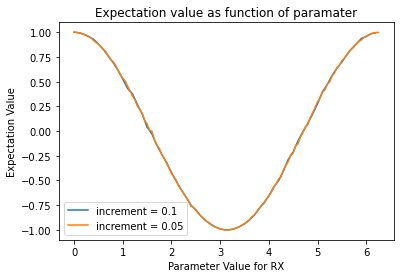

In [11]:
print("Ideal Simulation")
print(min_eigen(hamiltonian, 0.1))
print(min_eigen(hamiltonian, 0.05))

I begin with ideal multi - shot simulation of the VQE circuit. The measurement results are almost similar for the two increments I have tried as shown by the graph. However we get the exact minimum eigenvalue when increment is 0.05. This indicates that for the case where increment is 0.1, the eigenstate corresponding to the eigenvalue -1 may not have been generated. However the result for increment = 0.1 is fairly close to the correct result.

Noisy Simulation
-0.883
-0.8898


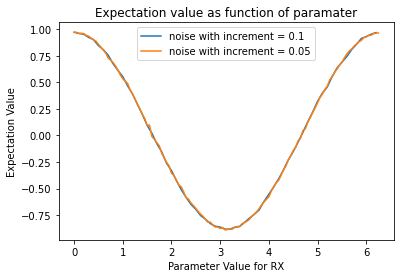

In [12]:
print("Noisy Simulation")
print(min_eigen(hamiltonian, 0.1, noise = True))
print(min_eigen(hamiltonian, 0.05, noise = True))

For the case of noisy simulation, the results do not have a good agreement with the actual minimum eigenvalue. The results however are fairly close to each other for the two cases of noisy simulation. The agreement to the actual result can be improved using error mitigation methods.

Error Mitigation of Noisy Simulation
-0.969860172352161
-0.971093371731949


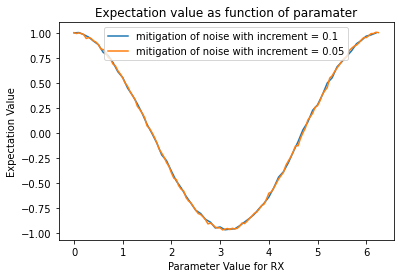

In [10]:
print("Error Mitigation of Noisy Simulation")
print(min_eigen(hamiltonian, 0.1, noise = True, error_mitigation = True))
print(min_eigen(hamiltonian, 0.05, noise = True, error_mitigation = True))

A calibration matrix is first calculated by executing the noise model on each of the basis states and measuring probability of getting counts of other basis states. This matrix is then used to calibrate the measurement results of executing the VQE circuit. Upon error mitigation, it is seen that the agreement of measurement results with the actual results and the results of ideal simulation increases and is fairly good though not excellent. However the exact result is not obtained for the values of increment I have tried. The agreement may however further increase as the value of increment is decreased (more trial states are created by the ansatz).

-0.9996
-0.8766
-0.9611915460774633


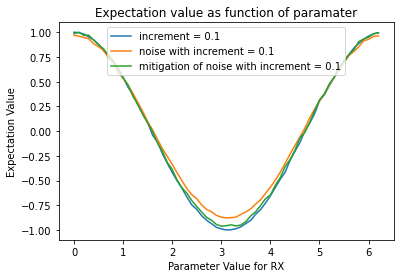

In [13]:
print(min_eigen(hamiltonian, 0.1))
print(min_eigen(hamiltonian, 0.1, noise = True))
print(min_eigen(hamiltonian, 0.1, noise = True, error_mitigation = True))

In these two graphs (above and below) I compare the results for the three types of simulation for a given value of increment. The results of noisy simulation do not show very good agreement with the results of ideal simulation, which is expected. The agreement of results of ideal simulation and error mitigated noisy simulation is fairly good. The results of error mitigation however do not fall within chemical accuracy (defined as being within 0.0016 Hartree of the exact result) for either value of increment. The agreement for a given value of increment can be increased by increasing the number of shots while calculating the calibration matrix.

-1.0
-0.8812
-0.9698549892553047


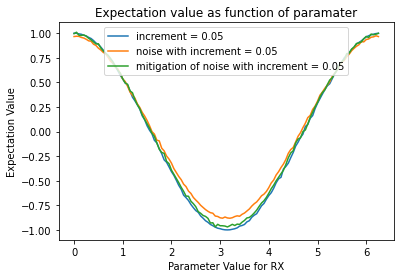

In [15]:
print(min_eigen(hamiltonian, 0.05))
print(min_eigen(hamiltonian, 0.05, noise = True))
print(min_eigen(hamiltonian, 0.05, noise = True, error_mitigation = True))

The above code finds the smallest eigenvalue taking into account the hints given (it uses the fact that the only Pauli terms will be II, XX, YY, ZZ). In order to be able to find the minimum eigenvalue for any general 2 x 2 Hermitian hamiltonian (it can be written as the sum of tensor products of Pauli matrices), I extend the code in the following manner. I consider only Hermitian matrices because observables in real world correspond to Hermitian matrices. Also, the concept of smallest eigenvalue exists only for those matrices all of whose eigenvalues are real. The simulation in both the codes is same, only the way of calculating the expectation value differs in order to account for all possible operators.

In [16]:
ix = np.kron(pauli_i, pauli_x)
iy = np.kron(pauli_i, pauli_y)
iz = np.kron(pauli_i, pauli_z)
xi = np.kron(pauli_x, pauli_i)
xy = np.kron(pauli_x, pauli_y)
xz = np.kron(pauli_x, pauli_z)
yi = np.kron(pauli_y, pauli_i)
yx = np.kron(pauli_y, pauli_x)
yz = np.kron(pauli_y, pauli_z)
zi = np.kron(pauli_z, pauli_i)
zx = np.kron(pauli_z, pauli_x)
zy = np.kron(pauli_z, pauli_y)

Although it is a bit tedious to write all the gates explicitly, it makes the resulting code a lot easily readable in my opinion. However, this cannot be done for a system of 3 qubits or more as it will be a bit too tedious.

In [17]:
pauli_gates = [pauli_i, pauli_x, pauli_y, pauli_z]
two_qubit_gates = [ii, ix, iy, iz, xi, xx, xy, xz, yi, yx, yy, yz, zi, zx, zy, zz]

def system_of_eq():
    matrix = []
    for gate in two_qubit_gates:
        matrix.append(list(gate.flat))
    return np.array(matrix).transpose()

def get_coefficients(hamiltonian):
    vector_b = np.array(list(hamiltonian.flat))
    matrix_a = system_of_eq()
    a_inverse = np.linalg.inv(matrix_a)
    coeff_vector = a_inverse.dot(vector_b)
    return coeff_vector

In [18]:
def change_bases(circuit, operator, num_qubit):
    if operator == 'x':
        circuit.ry(-np.pi/2, num_qubit)
    elif operator == 'y':
        circuit.rx(np.pi/2, num_qubit)
    return circuit

def vqe_circuit_2(parameter, operator):
    q = QuantumRegister(2)
    c = ClassicalRegister(2)
    circuit = QuantumCircuit(q, c)
    ansatz = make_ansatz(circuit, parameter)
    
    for i in range(2):
        circuit = change_bases(ansatz, operator[i], i)
    for i in range(2):
        circuit.measure(q[i], c[i])
    return circuit

In [19]:
def exp_val_op_2(parameter, operator, noise, error_mitigation):
    circuit = vqe_circuit_2(parameter, operator)
    
    counts = simulation(circuit, noise, error_mitigation)
    
    exp_val = 0
    meas2eigen = {'i' : {'0' : 1, '1' : 1}, 'x' : {'0' : 1, '1' : -1}, 'y' : {'0' : 1, '1' : -1}, 'z' : {'0' : 1, '1' : -1}}
    #meas2eigen tells the eigenvalues corresponding to the measurement result, for given operators
    for result in counts:
        eigenval = meas2eigen[operator[1]][result[0]] * meas2eigen[operator[0]][result[1]]
        #to find the eigenvalue, I multiply the eigenvalues corresponding to mesurement result for given operator
        #since the measurement result strings in qiskit are outputted in reverse order,
        #therefore result[0] corresponds to measurement outcome for second qubit in the two qubit circuit
        exp_val += eigenval * counts[result] / 5000
    return exp_val

In [20]:
def exp_val_hamil_2(parameter, hamiltonian, noise, error_mitigation):
    operators = ['ii', 'ix', 'iy', 'iz', 'xi', 'xx', 'xy', 'xz', 'yi', 'yx', 'yy', 'yz', 'zi', 'zx', 'zy', 'zz']
    coefficients = get_coefficients(hamiltonian)
    zero = 0 + 0j
    exp_val = 0
    for i in range(16):
        if coefficients[i] != zero:
            exp_val += coefficients[i] * exp_val_op_2(parameter, operators[i], noise, error_mitigation)
    return np.real(exp_val)
#Here we take only real part because hamiltonians are always hermitian operators
#So the expectation value is always real

In [21]:
def min_eigen_2(hamiltonian, increment, plot = True, noise = False, error_mitigation = False):
    min_eigenval = exp_val_hamil_2(0, hamiltonian, noise, error_mitigation)
    angle = 0
    angles = []
    exp_vals = []
    while angle < 2 * np.pi:
        exp_val = exp_val_hamil_2(angle, hamiltonian, noise, error_mitigation)
        if exp_val < min_eigenval:
            min_eigenval = exp_val
        if plot:
            angles.append(angle)
            exp_vals.append(exp_val)
        angle += increment
    if plot:
        label = 'increment = ' + str(increment)
        if noise:
            label = 'noise with ' + label
            if error_mitigation:
                label = 'mitigation of ' + label
        plot_graph(angles, exp_vals, label)
    return min_eigenval

Ideal Simulation
-0.9994000000000001
-1.0


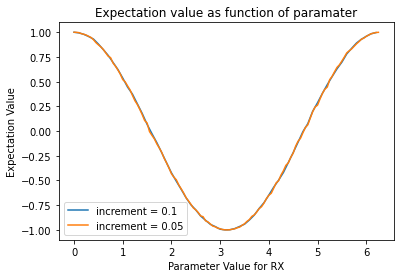

In [22]:
print("Ideal Simulation")
print(min_eigen_2(hamiltonian, 0.1))
print(min_eigen_2(hamiltonian, 0.05))

Since the simulation is the same as previous code, no difference in agreement to actual result is expected. However the result for increment = 0.1 here differs from that in the previous code because we only have a finite number of shots, so the probabilities obtained are not the same as the theoretical value.

Noisy Simulation
-0.8834
-0.881


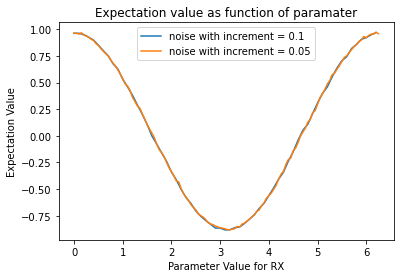

In [23]:
print("Noisy Simulation")
print(min_eigen_2(hamiltonian, 0.1, noise = True))
print(min_eigen_2(hamiltonian, 0.05, noise = True))

The noisy simulation here shows interesting output in the sense that here the agreement with the actual value decreases even after increasing the precision of the simulation (by decreasing the value of increment). This is proof to the fact that the effects of noise are not systematic and therefore it is very difficult to combat them entirely.

Error Mitigation of Noisy Simulation
-0.9630353652775905
-0.9803424664864122


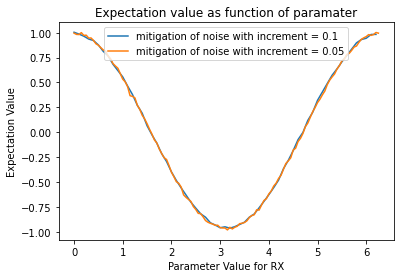

In [24]:
print("Error Mitigation of Noisy Simulation")
print(min_eigen_2(hamiltonian, 0.1, noise = True, error_mitigation = True))
print(min_eigen_2(hamiltonian, 0.05, noise = True, error_mitigation = True))

The results of error mitigation are similar to those obtained for the previous code, as was expected.

-0.9994000000000001
-0.8788
-0.9620229593091035


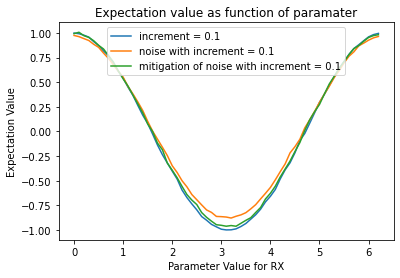

In [25]:
print(min_eigen_2(hamiltonian, 0.1))
print(min_eigen_2(hamiltonian, 0.1, noise = True))
print(min_eigen_2(hamiltonian, 0.1, noise = True, error_mitigation = True))

-1.0
-0.8826
-0.9745870421709999


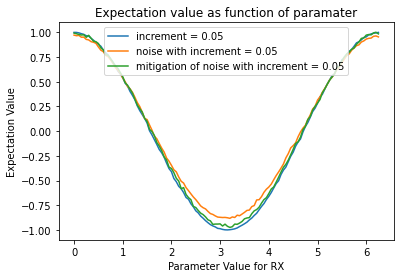

In [26]:
print(min_eigen_2(hamiltonian, 0.05))
print(min_eigen_2(hamiltonian, 0.05, noise = True))
print(min_eigen_2(hamiltonian, 0.05, noise = True, error_mitigation = True))

In the two graphs above, I again compare the agreement of ideal, noisy and error mitigated noisy simulation for a given value of increment. The agreement once again is fairly good for ideal and error mitigated noisy simulation, however it does not lie within chemical acuuracy as is expected because the simulation model is same.